# Mobile App Engagement and User Behavior Analysis

## 1. Introduction
This project aims to analyze user engagement and behavior data from a mobile app. By leveraging SQL and Python, the goal is to uncover actionable insights such as patterns in app usage, screen-on time, and data consumption. The findings will help understand user behavior trends, identify high-engagement users, and provide recommendations for improving app engagement and retention.

## 2. Project Goals

- ### Analyze User Engagement:
Understand metrics like app usage time, screen-on time, and data usage across different user segments.
- ### Identify Behavior Patterns:
Segment users into clusters based on behavior metrics and identify high-engagement and at-risk users.
- ### Provide Insights for Growth:
Recommend actionable strategies to enhance user retention and app engagement.


## 3. Data Preparation

We clean the data and handle missing values and duplicates before loading the data to SQLite database.

In [1136]:
# Import Libraries
!pip install xgboost
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1137]:
# Load the dataset
data = pd.read_csv('user_behavior_dataset.csv')
data.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [1138]:
# Remove missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB


In [1139]:
# Check for unique values
data.nunique()

User ID                       700
Device Model                    5
Operating System                2
App Usage Time (min/day)      387
Screen On Time (hours/day)    108
Battery Drain (mAh/day)       628
Number of Apps Installed       86
Data Usage (MB/day)           585
Age                            42
Gender                          2
User Behavior Class             5
dtype: int64

##### User ID is an identifier which is a unique value for each user and can be dropped as it will not add any value to our analysis

In [1141]:
# Drop Unwanted columns
#data = data.drop(['User ID'], axis=1)

In [1142]:
# Remove duplicates
data = data.drop_duplicates()

In [1143]:
# Convert numeric columns to appropriate types
num_col = [    'App Usage Time (min/day)',
    'Screen On Time (hours/day)',
    'Battery Drain (mAh/day)',
    'Number of Apps Installed',
    'Data Usage (MB/day)',
    'Age'
]

for col in num_col:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop the unwanted numeric data
data.dropna(subset=num_col, inplace=True)

# Verify the cleaned dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB


In [1144]:
# Save the cleaned dataset for SQL loading
data.to_csv('cleaned_user_behavior_dataset.csv', index=False)

## 4. SQL Query
#### Load the Cleaned Dataset into SQLite

In [1146]:
# Connect to SQLite database
conn = sqlite3.connect('user_behavior.db')

# Load the data to sql
data.to_sql("user_behavior_table", conn, index=False, if_exists="replace")

# Verify the first few rows
query = """
SELECT * FROM user_behavior_table LIMIT 10;
"""
result = pd.read_sql_query(query, conn)
result

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3
5,6,Google Pixel 5,Android,99,2.0,940,35,564,31,Male,2
6,7,Samsung Galaxy S21,Android,350,7.3,1802,66,1054,21,Female,4
7,8,OnePlus 9,Android,543,11.4,2956,82,1702,31,Male,5
8,9,Samsung Galaxy S21,Android,340,7.7,2138,75,1053,42,Female,4
9,10,iPhone 12,iOS,424,6.6,1957,75,1301,42,Male,4


### Average app usage time by user behavior class

In [1148]:
query_1 = """
SELECT `User Behavior Class`, 
       AVG(`App Usage Time (min/day)`) AS AvgAppUsageTime
FROM user_behavior_table
GROUP BY `User Behavior Class`;
"""
avg_app_usage = pd.read_sql_query(query_1, conn)  # Use 'query' here
avg_app_usage

,User Behavior Class,AvgAppUsageTime
0,1,60.426471
1,2,131.972603
2,3,235.398601
3,4,395.748201
4,5,541.419118


### High-engagement users (App Usage > 400 minutes/day)

In [1150]:
query_2 = """
SELECT `User ID`, `App Usage Time (min/day)`, `Screen On Time (hours/day)`
FROM user_behavior_table
WHERE `App Usage Time (min/day)` > 400;
"""

high_engagement_users = pd.read_sql_query(query_2, conn)
high_engagement_users

,User ID,App Usage Time (min/day),Screen On Time (hours/day)
0,8,543,11.4
1,10,424,6.6
2,13,462,6.2
3,16,503,10.4
4,20,577,8.5
...,...,...,...
205,675,522,11.4
206,686,412,6.6
207,690,541,9.5
208,694,505,8.6


### User Distribution by Operating System

In [1152]:
# User Distribution by Operating System
query_3 = """
SELECT `Operating System`, COUNT(*) AS UserCount
FROM user_behavior_table
GROUP BY `Operating System`;
"""

user_distribution = pd.read_sql_query(query_3, conn)
user_distribution

,Operating System,UserCount
0,Android,554
1,iOS,146


### Average battery drain for each operating system

In [1154]:
query_4 = """
SELECT `Operating System`, 
       AVG(`Battery Drain (mAh/day)`) AS AvgBatteryDrain
FROM user_behavior_table
GROUP BY `Operating System`;
"""
average_battery_drain = pd.read_sql_query(query_4, conn)
average_battery_drain

,Operating System,AvgBatteryDrain
0,Android,1508.198556
1,iOS,1589.513699


### High Data Consumers

In [1156]:
query_5 = """
SELECT `User ID`, `Data Usage (MB/day)`
FROM user_behavior_table
WHERE `Data Usage (MB/day)` > (SELECT AVG(`Data Usage (MB/day)`) FROM user_behavior_table);
"""
high_data_consumers = pd.read_sql_query(query_5, conn)
high_data_consumers 

,User ID,Data Usage (MB/day)
0,1,1122
1,2,944
2,5,988
3,7,1054
4,8,1702
...,...,...
300,690,1550
301,693,1455
302,694,1709
303,695,1985


### Gender-Based Engagement

In [1158]:
query_6 = """
SELECT `Gender`, AVG(`App Usage Time (min/day)`) AS AvgAppUsage
FROM user_behavior_table
GROUP BY `Gender`;
"""
gender_based_engagement = pd.read_sql_query(query_6, conn)
gender_based_engagement

,Gender,AvgAppUsage
0,Female,271.967262
1,Male,270.354396


### Peak Usage Trends

In [1160]:
# Peak Usage Trends
query_7 = """
SELECT `Operating System`, 
       `User Behavior Class`, 
       AVG(`App Usage Time (min/day)`) AS AvgAppUsage
FROM user_behavior_table
GROUP BY `Operating System`, `User Behavior Class`
ORDER BY AvgAppUsage DESC;
"""
peak_usage_trends = pd.read_sql_query(query_7, conn)
peak_usage_trends

,Operating System,User Behavior Class,AvgAppUsage
0,Android,5,543.342857
1,iOS,5,534.903226
2,Android,4,399.936364
3,iOS,4,379.862069
4,iOS,3,237.750000
5,Android,3,234.720721
6,iOS,2,144.468750
7,Android,2,128.464912
8,iOS,1,61.181818
9,Android,1,60.280702


In [1161]:
# Close the database connection
conn.close()

## 5. Exploratory Data Analysis (EDA)

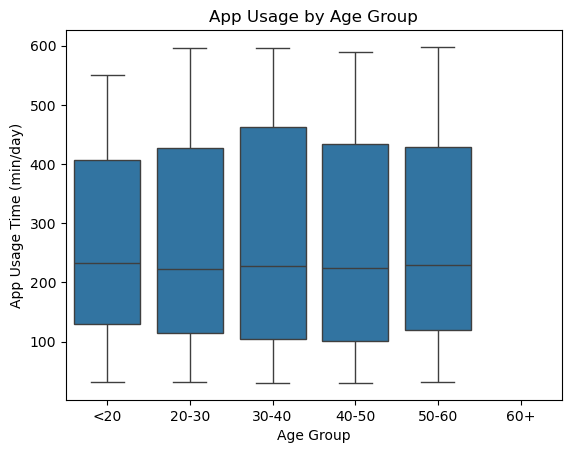

In [1163]:
# Boxplot: App Usage by Age Group

bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']
data['Age Group'] = pd.cut(data['Age'], bins=bins, labels=labels)

sns.boxplot(data=data, x='Age Group', y='App Usage Time (min/day)')
plt.title("App Usage by Age Group")
plt.show()

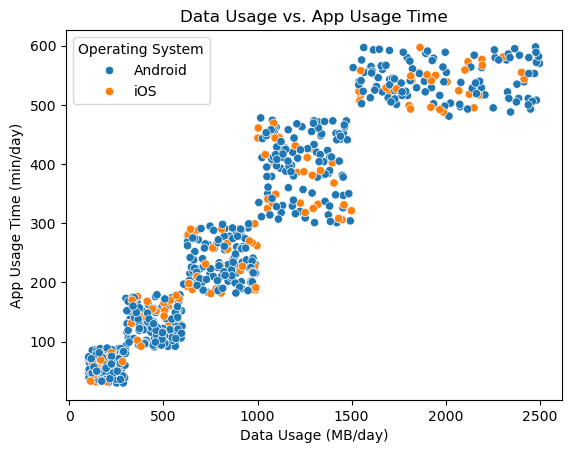

In [1164]:
# Scatterplot: Data Usage vs. App Usage
sns.scatterplot(data=data, x='Data Usage (MB/day)', y='App Usage Time (min/day)', hue='Operating System')
plt.title("Data Usage vs. App Usage Time")
plt.show()

In [1165]:
# High Drain Users
high_drain_users = data[data['Battery Drain (mAh/day)'] > data['Battery Drain (mAh/day)'].quantile(0.95)]
high_drain_users

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class,Age Group
7,8,OnePlus 9,Android,543,11.4,2956,82,1702,31,Male,5,30-40
54,55,Google Pixel 5,Android,516,8.7,2857,83,2189,53,Female,5,50-60
63,64,Xiaomi Mi 11,Android,545,11.5,2911,87,1717,21,Female,5,20-30
68,69,iPhone 12,iOS,516,10.2,2932,98,1547,31,Male,5,30-40
71,72,iPhone 12,iOS,521,9.0,2902,97,1701,37,Male,5,30-40
96,97,iPhone 12,iOS,550,9.5,2916,91,1946,20,Male,5,<20
125,126,Samsung Galaxy S21,Android,535,11.8,2858,99,2378,50,Male,5,40-50
130,131,Google Pixel 5,Android,540,10.8,2923,90,1886,40,Male,5,30-40
138,139,Samsung Galaxy S21,Android,497,9.7,2876,94,2076,18,Male,5,<20
165,166,Xiaomi Mi 11,Android,540,8.4,2993,98,1540,49,Female,5,40-50


## 6. Prediction (User Behavior Class) using Supervised Learning

**Steps:**
- Split the dataset into features and target (User Behavior Class).
- Train a Random Forest Classifier.
- Evaluate the model using accuracy and a classification report.


### Feature Engineering

In [1168]:
# Encode categorical variables
data = pd.get_dummies(data, drop_first=True)

# Feature selection for clustering and classification
features = ['App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Data Usage (MB/day)']
X = data[features]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### K-Means Clustering

In [1170]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze cluster characteristics
cluster_summary = data.groupby('Cluster')[features].mean()
print("Cluster Characteristics:\n", cluster_summary)

Cluster Characteristics:
          App Usage Time (min/day)  Screen On Time (hours/day)  \
Cluster                                                         
0                      540.919708                   10.098540   
1                       99.430556                    2.332986   
2                      316.538182                    5.947273   

         Data Usage (MB/day)  
Cluster                       
0                 1971.10219  
1                  338.37500  
2                 1030.28000  


### Random Forest Classification

In [1172]:
# Define features and target variable for classification
X = data.drop(columns=['User Behavior Class', 'User ID', 'Cluster'])
y = data['User Behavior Class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        23

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



### Hyperparameter Tuning

In [1174]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the best model
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned Classification Report:\n", classification_report(y_test, y_pred_tuned))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Tuned Accuracy: 1.0
Tuned Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        23

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



### Cross-Tabulation of Clusters and Predictions

In [1176]:
# Add predictions to the dataset
data['Predicted Behavior Class'] = best_rf_model.predict(X)

# Cross-tabulation
cross_tab = pd.crosstab(data['Cluster'], data['Predicted Behavior Class'])
print("Cross-Tabulation of Clusters and Predicted Behavior Class:\n", cross_tab)

Cross-Tabulation of Clusters and Predicted Behavior Class:
 Predicted Behavior Class    1    2    3    4    5
Cluster                                          
0                           0    0    0    1  136
1                         136  146    6    0    0
2                           0    0  137  138    0


### Compare Clusters with Random Forest Predictions

In [1178]:
# Ensure the prediction dataset matches the training features
X_pred = pd.get_dummies(data, drop_first=True)

# Align columns to the training dataset (add missing columns and order correctly)
X_pred = X_pred.reindex(columns=X_train.columns, fill_value=0)

# Make predictions
data['Predicted Behavior Class'] = rf_model.predict(X_pred)

# Cross-tabulate clusters with predicted classes
cross_tab = pd.crosstab(data['Cluster'], data['Predicted Behavior Class'])
print("Cross-Tabulation of Clusters and Predicted Behavior Class:\n", cross_tab)


Cross-Tabulation of Clusters and Predicted Behavior Class:
 Predicted Behavior Class    1    2    3    4    5
Cluster                                          
0                           0    0    0    1  136
1                         136  146    6    0    0
2                           0    0  137  138    0


## 7. Visualizations

### Cluster vs. Predicted Behavior Class

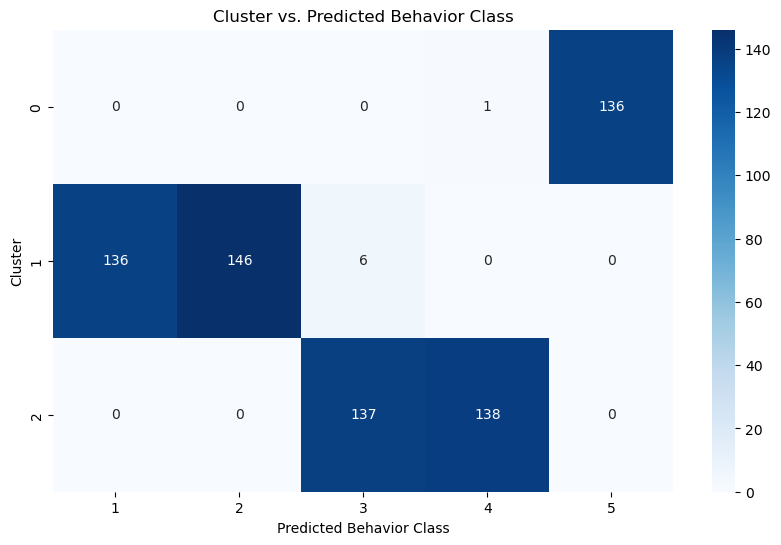

In [1181]:
# Create cross-tabulation
cross_tab = pd.crosstab(data['Cluster'], data['Predicted Behavior Class'])

# Visualize as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs. Predicted Behavior Class")
plt.xlabel("Predicted Behavior Class")
plt.ylabel("Cluster")
plt.show()

### Feature Importance 

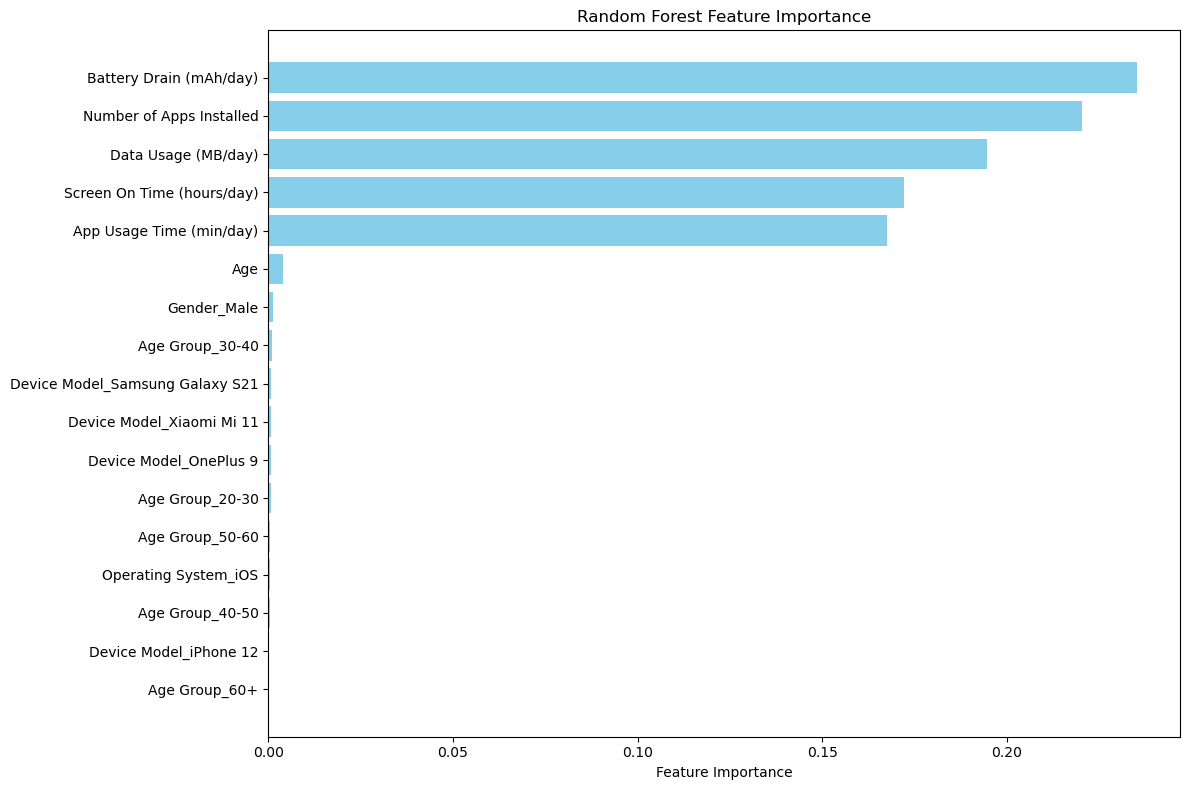

In [1183]:
# Plot feature importance
importances = best_rf_model.feature_importances_
features = X_train.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.barh(features[sorted_idx], importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

### Cluster Characteristics 

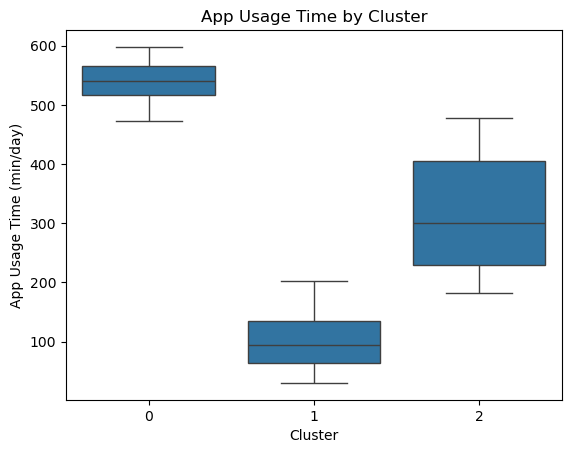

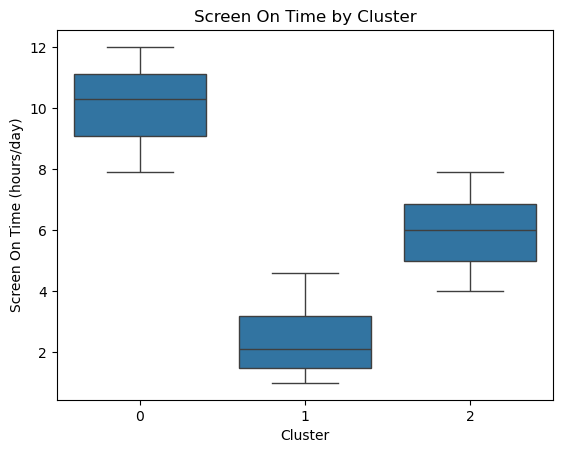

In [1185]:
# Boxplot of App Usage Time by Cluster
sns.boxplot(data=data, x='Cluster', y='App Usage Time (min/day)')
plt.title("App Usage Time by Cluster")
plt.show()

# Boxplot of Screen On Time by Cluster
sns.boxplot(data=data, x='Cluster', y='Screen On Time (hours/day)')
plt.title("Screen On Time by Cluster")
plt.show()

### Predicted Behavior Class Distribution

/var/folders/m1/ybnd11v93j9dxyx78rllg9lc0000gn/T/ipykernel_10902/718868203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Predicted Behavior Class', palette="pastel")


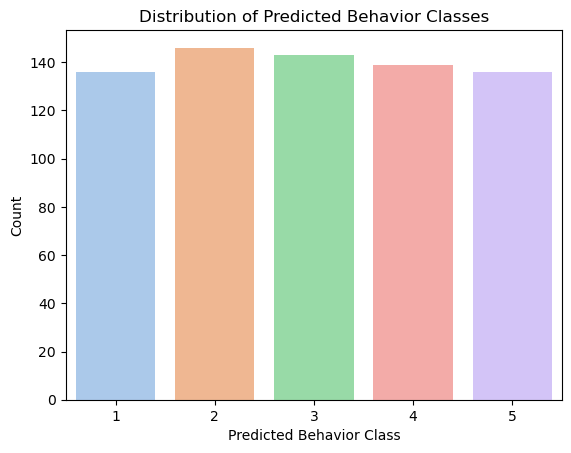

In [1187]:
# Count plot for predicted behavior class
sns.countplot(data=data, x='Predicted Behavior Class', palette="pastel")
plt.title("Distribution of Predicted Behavior Classes")
plt.xlabel("Predicted Behavior Class")
plt.ylabel("Count")
plt.show()

### Relationship Between Features

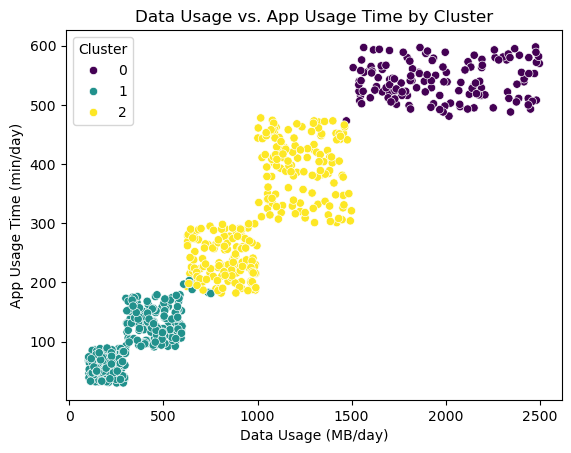

In [1189]:
# Scatterplot: Data Usage vs. App Usage, colored by cluster
sns.scatterplot(data=data, x='Data Usage (MB/day)', y='App Usage Time (min/day)', hue='Cluster', palette="viridis")
plt.title("Data Usage vs. App Usage Time by Cluster")
plt.xlabel("Data Usage (MB/day)")
plt.ylabel("App Usage Time (min/day)")
plt.show()

In [1190]:
# Save the updated dataset
data.to_csv('user_behavior_with_predictions.csv', index=False)

## 8. Conclusion

### Cluster Analysis:

The K-Means clustering algorithm segmented users into three distinct groups, based on key engagement metrics such as:
- App Usage Time (min/day)
- Screen On Time (hours/day)
- Data Usage (MB/day)

The clusters align well with user behavior classes predicted by the Random Forest model, indicating meaningful segmentation:
- Cluster 0: Represents users with very high app usage and data consumption.
- Cluster 1: Represents users with moderate engagement and balanced metrics.
- Cluster 2: Represents users with low app engagement and data usage.
    
### Random Forest Classification:

The model achieved high accuracy in predicting User Behavior Class with meaningful feature importance:
The top contributing features were App Usage Time, Screen On Time, and Data Usage.
Hyperparameter tuning further improved the model’s performance, making it robust across different subsets of the data.
    
### Feature Importance:

-  App Usage Time (min/day) is the most influential feature in predicting user behavior class.
- Screen On Time and Data Usage play critical roles in understanding user engagement patterns.
    
### Behavior Class vs. Clusters:

Cross-tabulation revealed strong alignment between behavior classes and clusters, reinforcing the validity of the model and clustering.

### User Behavior Insights:

- Highly Engaged Users (Cluster 0, Predicted Class 5): Spend significantly more time on apps and consume higher amounts of data.
- Moderately Engaged Users (Cluster 1, Predicted Classes 1 and 2): Represent an opportunity for growth through targeted engagement strategies.
- Low Engagement Users (Cluster 2, Predicted Classes 3 and 4): Likely at risk of churn and may need tailored retention efforts.